<a href="https://colab.research.google.com/github/mengyaoo/Stata_Code/blob/master/Mengyao_He_HW6_(IEOR_4404_Fall_2020).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IEOR 4404  Simulation (Fall 2020)**

**Homework 6  [Total points: 80 Points]**


**Due 11:59 PM, Dec 13**

Homework 6 consists of application-oriented exercises focusing on:
* `simpy` simulation of systems
* Variance reduction

The steps to finish the homework:

*   Step 1: Answer your homework on Google Colab.
*   Step 2: Submit the copy on Google Assignment

Before you submit your assignment, make sure to re-run your code from the beginning. (You can do so by first clicking Runtime/Reset All Runtimes and then clicking Runtime/Run all)



In [1]:
#Your Name: Mengyao He
#Your UNI: mh4048

In [2]:
#This imports all the packages you need for the homework
#Please run this first
import numpy as np
import pandas as pd

import scipy.special as spsp
import scipy.stats as spst

import matplotlib.pyplot as plt

%matplotlib inline

import sympy
!pip install simpy
import simpy
import copy
import collections
 

#Exercise 1 [30 Points]

##Setting


We are interested in simulating an application system using `simpy`. In this system, the unit of time is day, which may be non-integers.

An applicant may submit an application between $t=0$ and $t=100$. The submission time follows a homogeneous Poisson process with $\lambda=10$. Applications are then reviewed in the order that they are received. Each application needs to be reviewed by 2 people, potentially simultaneously.

At $t=90.375$ (9 am), a team of 10 admission officers will start the reviewing process. The time needed for an officer to review an application follows a uniform distribution between 0.05 and 0.1 days. After working for at least 0.375 days (9 hours), the officer will finish reviewing the current application  and then go home. Each officer resumes their work at 9 am the next day ($\lfloor t \rfloor +1.375$, where $t$ is the time that they went home).

The simulation stops when the officers finish reviewing all the applications submitted before $t=100$. 

**<font color="red">In this question, you are NOT allowed to use any built-in sampling function except np.random.rand() </font>**


##Q1. [25 Points]

For this system, we are interested in computing the average time between an application's submission and its review completion.

* Use `simpy` to construct the system. Make sure to comment on your code so that it is easy for the graders to understand your logic.
* Run the system once. Inside the function print out the following information for the first 50 submissions. For each submission, print out the 4 lines containing the following information:

>* `[submission id]  [start/finish] [time]  [reviewer 1 / reviewer 2]`

>* For example:`[1] [start] [90.375] [reviwer 1]`. means applicants 1's applications review process has started at t=0.4 by reviewer 1.

> * In total, you should print out 200 lines, These 200 lines should follow chronological order (time from smallest to largest). 


[Hint 1: Since all 10 officers are the identifical. Think carefully about how you can define your resources]

[Hint 2: It is useful to start two review processes for each application. One for reviewer 1 and one for reviwer 2. The review of an application will be over when both processes are processed]

[Hint 3: There are different ways to implement the system. The sample answer relied on priority resource to define requests with a higher priority to model the time period between going home and coming back to work for each worker]




In [3]:
def arrival(env,resources,outputs):
  submission_id = 0
  arrival_list = []
  time = 0
  end_time = 100.0
  lmbda = 10.0

  # accept submission before t=100
  while time <= end_time:
    inter_arrival = -1/lmbda * np.log(np.random.rand())
    time += inter_arrival

    # store the submission time for each submit
    outputs["submission_time"].append(time)
    outputs["submission_id"].append(submission_id)
    arrival_list.append(submission_id)
      # differentiate the submission by giving them accumulative ID
    submission_id += 1

  # At  t=90.375, a team of 10 admission officers will start the reviewing process
  yield env.timeout(90.375)
  while True:
    # stop service when no submissions
    if len(arrival_list) == 0:
      break
    # review submission arriving time 
    submission_id = arrival_list.pop(0)
    # make sure there will be two officers to review each submission
    env.process(serivce(env,resources,submission_id,outputs,1)) & env.process(serivce(env,resources,submission_id,outputs,2))


In [4]:
def serivce(env,resources,submission_id,outputs,reviwer):
  # request review
  request_list = [i.request(priority=0) for i in resources]
  # select officers who are available
  review = yield simpy.AnyOf(env, request_list)

  # assign to the first available officer
  officer_id = None
  not_taken = True
  for index, rqt in enumerate(request_list):
    if rqt in review and not_taken:
      # store the info of first available officer
      officer_id = index
      not_taken = False
    elif rqt in review and not_taken is False:
      # release the request from other available officers
      resources[index].release(rqt)
    else:
      # cancel the request if the officer is not availble
      rqt.cancel()
  
  # print out first 50 submissions info
  if submission_id < 50:
    print('submission id: %.f\t\t start time: %.3f\t\t reviewer %.f (officer %.f)' % (submission_id, env.now, reviwer, officer_id))
  service_time = np.random.rand() * 0.05 + 0.05
  yield env.timeout(service_time)
  resources[officer_id].release(request_list[officer_id])
  if submission_id < 50:
    print('submission id: %.f\t\t finish time: %.3f\t\t reviewer %.f (officer %.f)' % (submission_id, env.now, reviwer, officer_id))

  # collecting the completion time for reviews
  outputs['review' + str(reviwer) + '_complete_time'].append(env.now)


  # working hours is from 9-18, so here is 0.375 to 0.75
  if env.now - np.floor(env.now) >= 0.75:
    rest_rqt = resources[officer_id].request(priority=-1)
    yield rest_rqt
    # add 1.375 means officers come back to work next day
    yield env.timeout(1.375 + np.floor(env.now) - env.now)
    resources[officer_id].release(rest_rqt)


In [5]:
def system():
  outputs={"submission_time":[], "review1_complete_time":[], "review2_complete_time":[],"submission_id":[],"complete_time":[]}
  env=simpy.Environment()
  officer1=simpy.PriorityResource(env)
  officer2=simpy.PriorityResource(env)
  officer3=simpy.PriorityResource(env)
  officer4=simpy.PriorityResource(env)
  officer5=simpy.PriorityResource(env)
  officer6=simpy.PriorityResource(env)
  officer7=simpy.PriorityResource(env)
  officer8=simpy.PriorityResource(env)
  officer9=simpy.PriorityResource(env)
  officer10=simpy.PriorityResource(env)
  resources = [officer1,officer2,officer3,officer4,officer5,officer6,officer7,officer8,officer9,officer10]
  env.process(arrival(env,resources,outputs))
  env.run()
  return outputs

In [6]:
results = system()

submission id: 0		 start time: 90.375		 reviewer 1 (officer 0)
submission id: 0		 start time: 90.375		 reviewer 2 (officer 1)
submission id: 1		 start time: 90.375		 reviewer 1 (officer 2)
submission id: 1		 start time: 90.375		 reviewer 2 (officer 3)
submission id: 2		 start time: 90.375		 reviewer 1 (officer 4)
submission id: 2		 start time: 90.375		 reviewer 2 (officer 5)
submission id: 3		 start time: 90.375		 reviewer 1 (officer 6)
submission id: 3		 start time: 90.375		 reviewer 2 (officer 7)
submission id: 4		 start time: 90.375		 reviewer 1 (officer 8)
submission id: 4		 start time: 90.375		 reviewer 2 (officer 9)
submission id: 1		 finish time: 90.429		 reviewer 1 (officer 2)
submission id: 5		 start time: 90.429		 reviewer 1 (officer 2)
submission id: 2		 finish time: 90.434		 reviewer 2 (officer 5)
submission id: 5		 start time: 90.434		 reviewer 2 (officer 5)
submission id: 4		 finish time: 90.439		 reviewer 1 (officer 8)
submission id: 6		 start time: 90.439		 reviewer 1 (

In [7]:
for i in results["submission_id"]:
  results["complete_time"].append(max(results["review1_complete_time"][i],results["review2_complete_time"][i]))
  results["complete_time"][i]=results["complete_time"][i]-results["submission_time"][i]
np.mean(results["complete_time"])


57.362036194880965

In [8]:
pd.DataFrame(results)

,submission_time,review1_complete_time,review2_complete_time,submission_id,complete_time
0,0.058992,90.429316,90.433932,0,90.374939
1,0.204911,90.438928,90.442234,1,90.237323
2,0.713752,90.445919,90.447801,2,89.734049
3,0.721304,90.447402,90.467354,3,89.746049
4,0.738601,90.460063,90.474939,4,89.736339
...,...,...,...,...,...
1018,99.880153,127.515561,127.517937,1018,27.637784
1019,99.898875,127.520583,127.527871,1019,27.628996
1020,99.945328,127.527000,127.528907,1020,27.583579
1021,99.982457,127.533861,127.532792,1021,27.551404


##Q2. [5 Points]

* Comment out the print functions. Simulate the system 3 times and print out the system output each time. Again, the system output should be the average time between an application's submission and its review completion.


In [9]:
def serivce(env,resources,submission_id,outputs,reviwer):
  # request review without print function
  request_list = [i.request(priority=0) for i in resources]
  # select officers who are available
  review = yield simpy.AnyOf(env, request_list)

  # assign to the first available officer
  officer_id = None
  not_taken = True
  for index, rqt in enumerate(request_list):
    if rqt in review and not_taken:
      # store the info of first available officer
      officer_id = index
      not_taken = False
    elif rqt in review and not_taken is False:
      # release the request from other available officers
      resources[index].release(rqt)
    else:
      # cancel the request if the officer is not availble
      rqt.cancel()
  
  service_time = np.random.rand() * 0.05 + 0.05
  yield env.timeout(service_time)
  resources[officer_id].release(request_list[officer_id])

  # collecting the completion time for reviews
  outputs['review' + str(reviwer) + '_complete_time'].append(env.now)


  # working hours is from 9-18, so here is 0.375 to 0.75
  if env.now - np.floor(env.now) >= 0.75:
    rest_rqt = resources[officer_id].request(priority=-1)
    yield rest_rqt
    # add 1.375 means we are letting them come back to work next day
    yield env.timeout(1.375 + np.floor(env.now) - env.now)
    resources[officer_id].release(rest_rqt)


In [10]:
average_complete_time = []
for n in range(3):
  results = system()
  for i in results["submission_id"]:
    results["complete_time"].append(max(results["review1_complete_time"][i],results["review2_complete_time"][i]))
    results["complete_time"][i]=results["complete_time"][i]-results["submission_time"][i]
  average_complete_time.append(np.mean(results["complete_time"]))
average_complete_time

[57.538448849728276, 57.33705460330128, 56.70217836123184]

# Exercise 2 [50 Points]

##Setting
A company has 10 machines. At the beginning, all 10 machines all working properly. For each machine, after $\Delta t$ hours of operating, it will break down. This inter-breakdown time $\Delta t$ follows $ Exp(\lambda=0.1)$.

When a machine breaks down, this machine will immediately be taken to the maintenance room. The maintenance room can only fix one machine at a time. The machines will be fixed following first come first serve. The time it takes to fix the machine follows $Exp(\lambda=1)$.

After the machine is fixed, the machine will be sent back to the operation room immediately to perform tasks.  After $\Delta t$ hours of operating, the machine will break down again. Again, $\Delta t \sim Exp(\lambda=0.1)$.

**<font color="red">In this question, you are NOT allowed to use any built-in sampling function except np.random.rand() </font>**


##Q1. [20 points]

* Simulate the system using `simpy`. The simulation should stop when the number of operating machines goes below 7. For the system output, return the length of time from $t=0$ to the end of simulation. Make sure to comment on your code so that it is easy for the graders to understand your logic.
* Run the system 1000 times. Plot the distribution of the system output. 
* Report the lower bound, upper bound, and the length of the 95% confidence interval for the expected value of the system output.


In [11]:
def arrival(env, resource, id):
  break_lmbda = 0.1

  while True:
    # the breakage arrival for each machine
    inter_arrival = -1/break_lmbda * np.log(np.random.rand())
    yield env.timeout(inter_arrival)

    print('the machine %.f is broken at t=%.2f' % (id, env.now))
    
    # repair broken machine
    yield env.process(service(env, resource, id))
  
def service(env, resource, id):
  service_lmbda = 1
  # fixing time for repairing a broken machine
  inter_arrival = -1/service_lmbda*np.log(np.random.rand())

  # create repairing request
  rqt = resource.request()
  # check the number of operating machines goes below 7
  print('the number of broken machine is %.f \t\t ' % (len(resource.users) + len(resource.queue)))
  if len(resource.users) + len(resource.queue) > 3:
    raise simpy.Interrupt("the number of operating machines goes below 7!")

  # repairing the breakage
  yield rqt
  yield env.timeout(inter_arrival)
  # release the repairment request
  resource.release(rqt)
  print('the machine %.f is repaired at \t\t t=%.2f' % (id, env.now))




In [12]:
def system():
  env = simpy.Environment()
  # the maintenance room has only one capacity
  resource = simpy.Resource(env, capacity=1)
  # breakage process for 10 machines
  env.process(arrival(env, resource, id=1))
  env.process(arrival(env, resource, id=2))
  env.process(arrival(env, resource, id=3))
  env.process(arrival(env, resource, id=4))
  env.process(arrival(env, resource, id=5))
  env.process(arrival(env, resource, id=6))
  env.process(arrival(env, resource, id=7))
  env.process(arrival(env, resource, id=8))
  env.process(arrival(env, resource, id=9))
  env.process(arrival(env, resource, id=10))
  try:
    env.run()
  except:
    return env.now

In [13]:
system()

the machine 8 is broken at t=3.67
the number of broken machine is 1 		 
the machine 8 is repaired at 		 t=4.69
the machine 6 is broken at t=5.31
the number of broken machine is 1 		 
the machine 6 is repaired at 		 t=6.80
the machine 2 is broken at t=7.21
the number of broken machine is 1 		 
the machine 2 is repaired at 		 t=8.05
the machine 3 is broken at t=8.13
the number of broken machine is 1 		 
the machine 1 is broken at t=8.47
the number of broken machine is 2 		 
the machine 3 is repaired at 		 t=8.94
the machine 1 is repaired at 		 t=10.48
the machine 7 is broken at t=10.69
the number of broken machine is 1 		 
the machine 10 is broken at t=10.69
the number of broken machine is 2 		 
the machine 5 is broken at t=12.15
the number of broken machine is 3 		 
the machine 7 is repaired at 		 t=14.04
the machine 10 is repaired at 		 t=14.50
the machine 5 is repaired at 		 t=14.52
the machine 6 is broken at t=15.45
the number of broken machine is 1 		 
the machine 6 is repaired at 	

27.796391362984675

In [14]:
# function without print function
def arrival(env, resource, id):
  break_lmbda = 0.1
  while True:
    # the breakage arrival for each machine
    inter_arrival = -1/break_lmbda * np.log(np.random.rand())
    yield env.timeout(inter_arrival)

    # repair broken machine
    yield env.process(service(env, resource, id))
  
def service(env, resource, id):
  service_lmbda = 1
  # fixing time for repairing a broken machine
  inter_arrival = -1/service_lmbda*np.log(np.random.rand())

  # create repairing request
  rqt = resource.request()
  # check the number of operating machines goes below 7
  if len(resource.users) + len(resource.queue) > 3:
    raise simpy.Interrupt("the number of operating machines goes below 7!")

  # repairing the breakage
  yield rqt
  yield env.timeout(inter_arrival)
  # release the repairment request
  resource.release(rqt)




95% confidence interval 13.537759400822615 15.105597701324609
length of 95% confidence interval 1.5678383005019931


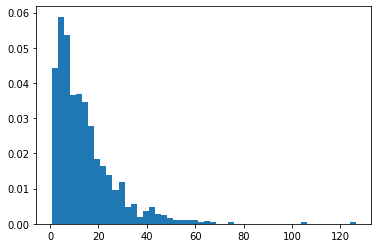

In [15]:
N = 1000
system_time = np.array([system() for i in range(1000)])
plt.hist(system_time, bins=50, density=True)

mean = np.mean(system_time)
std = np.std(system_time,ddof=1)
lower = mean - spst.norm.ppf(0.975) * std/N**0.5
upper = mean + spst.norm.ppf(0.975) * std/N**0.5
print("95% confidence interval", lower, upper)
print("length of 95% confidence interval", upper-lower)

##Q2. [10 Points]

Apply antithetic method to the fixing time and the inter-breakdown time. 

* Report the lower bound, upper bound, and the width of the 95% confidence interval for the expected value of the system output.


In [16]:
def arrival(env, resource, id, arrival_RS, service_RS, anti):
  break_lmbda = 0.1
  while True:
    u=arrival_RS.rand()
    if anti==1:
        u=1-u
    inter_arrival=-1/break_lmbda*np.log(u)
    yield env.timeout(inter_arrival)

    # repair broken machine
    yield env.process(service(env, resource, id, service_RS, anti))
  
def service(env, resource, id, service_RS, anti):
  service_lmbda = 1
  # fixing time for repairing a broken machine
  u=service_RS.rand()
  if anti==1:
      u=1-u
  inter_arrival=-1/service_lmbda*np.log(u)

  # create repairing request
  rqt = resource.request()
  # check the number of operating machines goes below 7
  if len(resource.users) + len(resource.queue) > 3:
    raise simpy.Interrupt("the number of operating machines goes below 7!")

  # repairing the breakage
  yield rqt
  yield env.timeout(inter_arrival)
  # release the repairment request
  resource.release(rqt)



In [17]:
def system(arrival_RS, service_RS, anti):
  env = simpy.Environment()
  # the maintenance room has only one capacity
  resource = simpy.Resource(env, capacity=1)
  # breakage process for 10 machines
  env.process(arrival(env, resource, 1, arrival_RS, service_RS, anti))
  env.process(arrival(env, resource, 2, arrival_RS, service_RS, anti))
  env.process(arrival(env, resource, 3, arrival_RS, service_RS, anti))
  env.process(arrival(env, resource, 4, arrival_RS, service_RS, anti))
  env.process(arrival(env, resource, 5, arrival_RS, service_RS, anti))
  env.process(arrival(env, resource, 6, arrival_RS, service_RS, anti))
  env.process(arrival(env, resource, 7, arrival_RS, service_RS, anti))
  env.process(arrival(env, resource, 8, arrival_RS, service_RS, anti))
  env.process(arrival(env, resource, 9, arrival_RS, service_RS, anti))
  env.process(arrival(env, resource, 10, arrival_RS, service_RS, anti))
  try:
    env.run()
  except simpy.Interrupt:
    return env.now

def system_avg():
    arrival_RS=np.random.RandomState()
    arrival_anti=copy.copy(arrival_RS)

    service_RS=np.random.RandomState()
    service_anti=copy.copy(service_RS)

    output1=system(arrival_RS, service_RS, 0)
    output2=system(arrival_anti, service_anti,1)
    return (output1+output2)/2

In [18]:
system_avg()

12.702802883742875

95% confidence interval 13.969909316478617 14.895686482691094
length of 95% confidence interval 0.9257771662124767


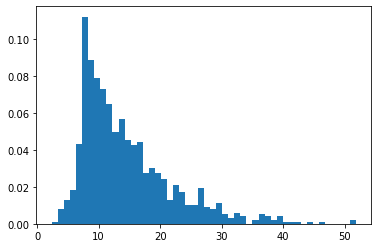

In [19]:
N = 1000
system_time = np.array([system_avg() for i in range(1000)])
plt.hist(system_time, bins=50, density=True)

mean = np.mean(system_time)
std = np.std(system_time,ddof=1)
lower = mean - spst.norm.ppf(0.975) * std/N**0.5
upper = mean + spst.norm.ppf(0.975) * std/N**0.5
print("95% confidence interval", lower, upper)
print("length of 95% confidence interval", upper-lower)

##Q3. [10 Points]

Apply control variate method to the the fixing time of the first breakdown machine.

* Report the lower bound, upper bound, and the width of the 95% confidence interval for the expected value of the system output.



In [20]:
def arrival(env, resource, repair_time, id):
  break_lmbda = 0.1
  while True:
    # the breakage arrival for each machine
    inter_arrival = -1/break_lmbda * np.log(np.random.rand())
    yield env.timeout(inter_arrival)

    # repair broken machine
    yield env.process(service(env, resource, repair_time, id))
  
def service(env, resource, repair_time, id):
  service_lmbda = 1
  # fixing time for repairing a broken machine
  inter_arrival = -1/service_lmbda*np.log(np.random.rand())

  # create repairing request
  rqt = resource.request()
  # check the number of operating machines goes below 7
  if len(resource.users) + len(resource.queue) > 3:
    raise simpy.Interrupt("the number of operating machines goes below 7!")

  # repairing the breakage
  yield rqt
  yield env.timeout(inter_arrival)
  repair_time.append(env.now)
  # release the repairment request
  resource.release(rqt)




In [21]:
def system():
  repair_time = []
  env = simpy.Environment()
  # the maintenance room has only one capacity
  resource = simpy.Resource(env, capacity=1)
  # breakage process for 10 machines
  env.process(arrival(env, resource, repair_time, id=1))
  env.process(arrival(env, resource, repair_time, id=2))
  env.process(arrival(env, resource, repair_time, id=3))
  env.process(arrival(env, resource, repair_time, id=4))
  env.process(arrival(env, resource, repair_time, id=5))
  env.process(arrival(env, resource, repair_time, id=6))
  env.process(arrival(env, resource, repair_time, id=7))
  env.process(arrival(env, resource, repair_time, id=8))
  env.process(arrival(env, resource, repair_time, id=9))
  env.process(arrival(env, resource, repair_time, id=10))
  try:
    env.run()
  except:
    if len(repair_time) == 0:
      repair_time = [env.now]
    return env.now, repair_time[0]

95% confidence interval 13.764222242565815 15.42483247392435
mean 14.594527358245083
width of confidence interval 1.660610231358536


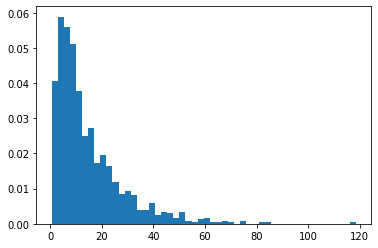

In [22]:
N=1000
result=[system() for i in range(N)]
result=np.array(result)
x=result[:,0]
z=result[:,1]
c=-np.cov(x,z,ddof=1)[0,1]/np.var(z,ddof=1)
y=x+c*(z-1/11)

plt.hist(y, bins=50, density=True)

mean=np.mean(y)
std=np.std(y,ddof=1)
lower=mean-spst.norm.ppf(0.975)*std/N**0.5
upper=mean+spst.norm.ppf(0.975)*std/N**0.5
print("95% confidence interval", lower,upper)
print("mean", mean)
print("width of confidence interval",upper-lower)

##Q4.  [10 points]

Now, let's continue from Q1. Suppose the maintenance room will be closed for 0.2 hours after every 0.8 hours of opening. During this time, the repairmen will not fix any machine. After the maintenance room reopens, the repairmen will resume fixing the machines. If at the time of break, the repairmen have taken $x'$ period of time to fix a machine and the amount of the time to fix the machine is $x$, the machine will now need $x-x'$ amount of time to get fixed.

* Run the system 1000 times. Plot the distribution of the time it takes for the number of operating machines to go below 7.

[hint: one solution is to define the maintenance room as a preemptive resource, and treat closing as a request]

In [23]:
def arrival(env, resource, id,break_list):
  break_lmbda = 0.1
  while True:
    # the breakage arrival for each machine
    inter_arrival = -1/break_lmbda * np.log(np.random.rand())
    yield env.timeout(inter_arrival)
    break_list.append(id)
    
    yield env.process(service(env, resource, id, break_list))
  

def close_room_arrival(env, resource):
  while True:
    # close the maintenance room after every 0.8 hours
    yield env.timeout(0.8)
    yield env.process(close_room(env, resource))
   

def close_room(env, resource):
  rqt = resource.request(priority=-100, preempt=True)
  yield rqt
  yield env.timeout(0.2)
  resource.release(rqt)

def service(env, resource, id, break_list, priority=0, remaining_time=0):
  # checking if it is a remaining request
  lmbda_service = 1
  if remaining_time > 0:
    inter_arrival = remaining_time
    preempt = True
  else:
    inter_arrival = -1/lmbda_service*np.log(np.random.rand())
    preempt = False
  
  rqt = resource.request(priority=priority, preempt=preempt)
  
  if len(break_list) > 3:
    raise simpy.Interrupt("the number of operating machines goes below 7!")
  yield rqt

  try:
    # if the repairment is not interrupt by the closure
    yield env.timeout(inter_arrival)
  except simpy.Interrupt as interrupt:
    usage = env.now - interrupt.cause.usage_since
    remaining_time = inter_arrival - usage
    rqt.cancel()
    yield env.process(service(env, resource, id, break_list, priority=-2, remaining_time=remaining_time))
  
  else:
    resource.release(rqt)
    break_list.pop(0)
  

def system(debug=False):
  env = simpy.Environment()
  break_list = []
  resource = simpy.PreemptiveResource(env, capacity=1)
  env.process(close_room_arrival(env, resource))
  env.process(arrival(env, resource, id=1, break_list=break_list))
  env.process(arrival(env, resource, id=2, break_list=break_list))
  env.process(arrival(env, resource, id=3, break_list=break_list))
  env.process(arrival(env, resource, id=4, break_list=break_list))
  env.process(arrival(env, resource, id=5, break_list=break_list))
  env.process(arrival(env, resource, id=6, break_list=break_list))
  env.process(arrival(env, resource, id=7, break_list=break_list))
  env.process(arrival(env, resource, id=8, break_list=break_list))
  env.process(arrival(env, resource, id=9, break_list=break_list))
  env.process(arrival(env, resource, id=10, break_list=break_list))
  try:
    env.run()
  except:
    return env.now

In [24]:
system()

3.948671495574534

95% confidence interval 10.5461647520781 11.699061807440069
length of 95% confidence interval 1.1528970553619686


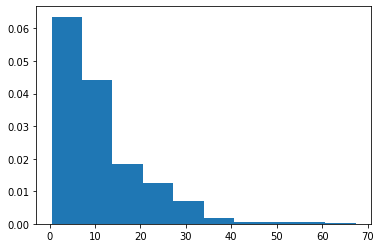

In [27]:
N = 1000
system_time = np.array([system() for i in range(1000)])
plt.hist(system_time, density=True)

mean = np.mean(system_time)
std = np.std(system_time,ddof=1)
lower = mean - spst.norm.ppf(0.975) * std/N**0.5
upper = mean + spst.norm.ppf(0.975) * std/N**0.5
print("95% confidence interval", lower, upper)
print("length of 95% confidence interval", upper-lower)